# Interactive model evaluation with Trident Chemwidgets

In this tutorial we'll build on the [*Introduction to Graph Covolutions* tutorial](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Graph_Convolutions.ipynb) to show how you can use the [Trident Chemwidgets](https://github.com/tridentbio/trident-chemwidgets) (TCW) package to interact with and test the model you've trained.

Evaluating models on new data, including corner cases, is a critical step toward model deployment. However, generating new molecules to test in an interactive way is rarely straightforward. TCW provides several tools to help subset larger datasets and draw new molecules to test against your models. You can find the full documentation for the Trident Chemwidgets library [here](https://www.trident.bio/trident-chemwidgets/html/index.html). 

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Interactive_model_evaluation_with_Trident_Chemwidgets.ipynb)

# Installing the prerequisites

In [ ]:
!pip install tensorflow~=2.4
!pip install deepchem trident-chemwidgets seaborn

For this tutorial, you'll need Trident Chemwidgets version 0.2.0 or greater. We can check the installed version with the following command:

In [1]:
import trident_chemwidgets as tcw
print(tcw.__version__)

0.2.1


Throughout this tutorial, we'll use the convention `tcw` to call the classes from the Trident Chemwidgets package.

# Exploring the data

We'll start out by loading the Tox21 dataset and extracting the predefined train, validation, and test splits.

In [2]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

We can then use RDKit to calculate some additional features for each of the training examples. Specifically, we'll compute the [logP](https://en.wikipedia.org/wiki/Partition_coefficient) and [molecular weight](https://en.wikipedia.org/wiki/Molecular_mass) of each molecule and return this new data in a dataframe.

In [3]:
import rdkit.Chem as Chem
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.Descriptors import MolWt
import pandas as pd

data = []

for dataset, split in zip(datasets, ['train', 'valid', 'test']):
    for smiles in dataset.ids:
        mol = Chem.MolFromSmiles(smiles)
        logp = MolLogP(mol)
        mwt = MolWt(mol)
        data.append({
            'smiles': smiles,
            'logp': logp,
            'mwt': mwt,
            'split': split
        })
        
mol_data = pd.DataFrame(data)

mol_data.head()

[15:36:55] WARNING: not removing hydrogen atom without neighbors


,smiles,logp,mwt,split
0,CC(O)(P(=O)(O)O)P(=O)(O)O,-0.9922,206.027,train
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,4.8172,290.444,train
2,OC[C@H](O)[C@@H](O)[C@H](O)CO,-2.9463,152.146,train
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],2.1911,351.802,train
4,CC(C)COC(=O)C(C)C,1.8416,144.214,train


## One-dimensional distributions

We can examine one-dimensional distributions using a histogram. Unlike histograms from static plotting libraries like Matplotlib or Seaborn, the TCW Histogram provides interactive functionality. TCW enables subsetting of the data, plotting chemical structures in a gallery next to the plot, and saving a reference to the subset portion of the dataframe. Unfortunately, this interactivity comes at the price of portability, so we have included screenshots for this tutorial in addition to providing the code to generate the interactive visuals. If you run this tutorial yourself (either locally or on Colab), you'll be able to display and interact with full demo plots.

In the plot below, you can see the histogram of the molecular weight distribution from the combined dataset on the left. If you click and drag within plot area in the live widget, you can subset a portion of the distribution for further examination. The background of the selected portion will turn gray and the selected data points will be shown in teal within the bars of the plot. The x axis of the Histogram widget is compatible with either numeric or date data types, which makes it a convenient choice for splitting your ML datasets based on a property or the date the experimental data were collected.

<img src="./assets/trident_chemwidgets_data/Histogram.png" alt="Histogram example" width="1000"/>

To generate an interactive example of the widget, run the next cell:

In [4]:
hist = tcw.Histogram(data=mol_data, smiles='smiles', x='mwt')
hist

Histogram(data={'points': [{'smiles': 'CC(O)(P(=O)(O)O)P(=O)(O)O', 'x': 206.027, 'index': 0}, {'smiles': 'CC(C…

If you select subset of the data by clicking and dragging, you can view the selected structures in the gallery to the right by pressing the `SHOW STRUCTURES` button beneath the plot. You can extract this subset of the original dataframe by pressing `SAVE SELECTION` and accessing the `hist.selection` property as shown in the next cell. This workflow is convenient for applications like data splitting based on a single dimension.

In [5]:
hist.selection

,smiles,logp,mwt,split


## Two- or three-dimensional distributions

In addition to histograms, TCW also has provides a class for scatter plots. The Scatter class is useful when comparing two or three dimensions or your data. As of v0.2.0, TCW Scatter supports the use of the x and y axes as well as the color of each point (`hue` keyword) to represent either continuous or discrete variables. Just like in the Histogram example, you can click and drag within the plot area to subset along the x and y axes. The Scatter widget also supports dates along the x, y, and hue axes.

In the image below, we have selected a portion of dataset with large molecular weight values, but minimal training examples (displayed points in orange), to demonstrate how the Scatter widget can be useful for outlier identification. In addition to selection by bounding box, you can also hover over individual points to display a drawing of the underlying structure.

<img src="./assets/trident_chemwidgets_data/Scatter.png" alt="Scatter example" width="1000"/>

To generate an interactive example of the widget, run the next cell:

In [6]:
scatter = tcw.Scatter(data=mol_data, smiles='smiles', x='mwt', y='logp', hue='split')
scatter

Scatter(data={'points': [{'smiles': 'CC(O)(P(=O)(O)O)P(=O)(O)O', 'x': 206.027, 'y': -0.9922000000000002, 'hue'…

If you select subset of the data by clicking and dragging, you can view the selected structures in the gallery to the right by pressing the `SHOW STRUCTURES` button beneath the plot. You can extract this subset of the original dataframe by pressing `SAVE SELECTION` and accessing the `scatter.selection` property as shown in the next cell.

In [7]:
scatter.selection

,smiles,logp,mwt,split


# Training a GraphConvModel

Now that we've had a look at the training data, we can train a GraphConvModel to predict the 12 Tox21 classes. We'll replicate the training procedure exactly from the [*Introduction to Graph Covolutions* tutorial](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Graph_Convolutions.ipynb). We'll train for 50 epochs, just as in the original tutorial.

In [8]:
# The next line filters tensorflow warnings relevant to memory consumption.
# To see these warnings, comment the next line.
import warnings; warnings.filterwarnings('ignore')

# Now we'll set the tensorflow seed to make sure the results of this notebook are reproducible
import tensorflow as tf; tf.random.set_seed(27)

n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks, mode='classification')
model.fit(train_dataset, nb_epoch=50)

2022-06-29 15:37:03.915828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.2661594772338867

Now that we have a trained model, we can check AUROC values for the training and test datasets:

In [9]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print(f'Training set score: {model.evaluate(train_dataset, [metric], transformers)["roc_auc_score"]:.2f}')
print(f'Test set score: {model.evaluate(test_dataset, [metric], transformers)["roc_auc_score"]:.2f}')

Training set score: 0.97
Test set score: 0.68


Just as in the original tutorial, we see that the model performs reasonably well on the predefined train/test splits. Now we'll use this model to evaluate compounds that are outside the training distribution, just as we might in a real-world drug discovery scenario.

# Evaluating the model on new data

One of the challenging first steps toward deploying an ML model in production is evaluating it on new data. Here, new data refers to both data outside the initial train/val/test distributions and also data that may not be already processed for use with the model.

We can use the JSME widget provided by TCW to quickly test our model again some molecules of interest. We'll start with a known therapeutic molecule: ibuprofen. We can see that ibuprofen is not included in any of the datasets that we have evaluated our model against so far:

In [10]:
print(f"Ibuprofen structure in Tox21 dataset: {'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O' in mol_data['smiles']}")

Ibuprofen structure in Tox21 dataset: False


To simulate a drug discovery application, let's say you're a chemist tasked with identifying potential new therapeutics derived from ibuprofen. Ideally, the molecules you test would have limited toxicity. You've just developed the model above to predict the tox outcomes from Tox21 data and now you want to use it to do some first-pass screening of your derivatives. The standard workflow for a task like this might include drawing the molecules in a program like ChemDraw, exporting to SMILES format, importing into the notebook, then prepping the data and running it through your model.

With TCW, we can shortcut the first few steps of that workflow by using the [JSME](https://jsme-editor.github.io/help.html) widget to draw molecules and convert to SMILES directly in the notebook. We can even use the `base_smiles` argument to specify a base molecular structure, which is great for generating derivatives. Here we'll set the base_smiles value to `'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O'`, the SMILES string for ibuprofen. Below is a screenshot using JSME to generate a few derivative molecules to test against our toxicity model.

<img src="./assets/trident_chemwidgets_data/JSME.png" alt="JSME example" width="1000"/>

To generate your own set of derivatives, run the cell below. To add a SMILES string to the saved set, click the `ADD TO SMILES LIST` button below the interface. If you want to regenerate the original base molecule, in this case ibuprofen, click the `RESET TO BASE SMILES` button below the interface. By using this button, it's easy to generate distinct derivatives from a shared starting structure.  Go ahead and create some ibuprofen derivatives to test against the tox model:

In [11]:
jsme = tcw.JSME(base_smiles='CC(C)CC1=CC=C(C=C1)C(C)C(=O)O')
jsme

JSME(base_smiles='CC(C)CC1=CC=C(C=C1)C(C)C(=O)O')

You can access the smiles using the `jsme.smiles` property. This call will return a list of the SMILES strings that have been added to the SMILES list of the widget (the ones shown in the molecule gallery to the right of the JSME interface).

In [12]:
print(jsme.smiles)

[]


To ensure the rest of this notebook runs correctly, the following cell sets the new test SMILES set to the ones from the screenshot above in the case that you have not defined your own set using the widget. Otherwise, it will use the molecules you have drawn.

In [13]:
# This cell will provide a preset list of SMILES strings in case you did not create your own.
if len(jsme.smiles) > 1:
    drawn_smiles = jsme.smiles
else:
    drawn_smiles = [
        'CC(C)Cc1ccc(C(C)C(=O)O)cc1',
        'CC(C)C(S)c1ccc(C(C)C(=O)O)cc1',
        'CCSC(c1ccc(C(C)C(=O)O)cc1)C(C)CC',
        'CCSC(c1ccc(C(C)C(=O)O)cc1)C(C)C(=O)O',
        'CC(C(=O)O)c1ccc(C(S)C(C)C(=O)O)cc1'
    ]

Next we have to create a dataset that is compatible with our model to test these new molecules.

In [14]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.InMemoryLoader(tasks=list(train_dataset.tasks), featurizer=featurizer)
dataset = loader.create_dataset(drawn_smiles, shard_size=1)

Finally, we can generate our predictions of positive results here and plot them.

<AxesSubplot:>

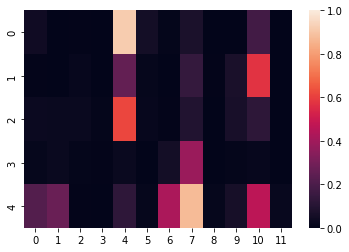

In [15]:
predictions = model.predict(dataset, transformers)[:, :, 1]

import seaborn as sns
sns.heatmap(predictions, vmin=0, vmax=1)

Now we can get the predicted most toxic compound/assay result for further inspection. Below we extract the highest predicted positive hit (most toxic) and display the assay name, SMILES string, and an image of the structure.

Most toxic result (predicted): NR-ER, CC(C)Cc1ccc(C(C)C(=O)O)cc1


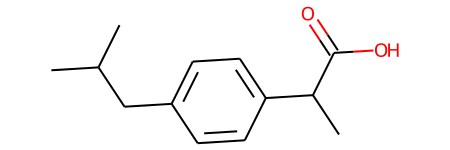

In [16]:
import numpy as np

mol_idx, assay_idx = np.unravel_index(predictions.argmax(), predictions.shape)
smiles = drawn_smiles[mol_idx]

print(f'Most toxic result (predicted): {train_dataset.tasks[assay_idx]}, {smiles}')
mol = Chem.MolFromSmiles(smiles)
mol

# Interpreting the model's predictions

Often predictions alone are insufficient to decide whether to move forward with costly experiments. We might also want some metric or metrics that allow us to interpret the model's output.

Building on the tutorial [Calculating Atomic Contributions for Molecules Based on a Graph Convolutional QSAR Model](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Atomic_Contributions_for_Molecules.ipynb), we can calculate the relative contribution of each atom in a molecule to the predicted output value. This attribution strategy enables us to determine whether the molecular features that a chemist may identify as important and those most affecting the predictions are in alignment. If the chemist's interpretation and the model's interpretation metrics are consistent, that may indicate that the model is a good fit for the task at hand. However, the inverse is not necessarily true either. A model may have the capacity to make accurate predictions that a trained chemist cannot fully understand. This is just one tool in a machine learning practitioner's toolbox.

We'll start by using the built-in `per_atom_fragmentation` argument for the `ConvMolFeaturizer`. This will generate a list of ConvMol objects that have each had a single atom removed.

In [17]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True)
mol_list = featurizer(smiles)
loader = dc.data.InMemoryLoader(tasks=list(train_dataset.tasks),
                                featurizer=dc.feat.DummyFeaturizer())
dataset = loader.create_dataset(mol_list[0], shard_size=1)

We can then run these predictions through the model and retrieve the predicted values for the molecule and assay specified in the last section.

In [18]:
full_molecule_prediction = predictions[mol_idx, assay_idx]
fragment_predictions = model.predict(dataset, transformers)[:, assay_idx, 0]
contributions = pd.DataFrame({
    'Change in predicted toxicity': 
    (full_molecule_prediction - fragment_predictions).round(3)
})

We can use the InteractiveMolecule widget from TCW to superimpose the contribution scores on the molecule itself, allowing us to easily asses the relative importance of each atom to the final prediction. If you click on one of the atoms, you can retrieve the contribution data in a card shown to the right of the structure. In this panel you can also select a variable by which to color the atoms in the plot.

<img src="./assets/trident_chemwidgets_data/InteractiveMolecule.png" alt="InteractiveMolecule example" width="1000"/>

You can generate the interactive widget by running the cell below.

In [19]:
tcw.InteractiveMolecule(smiles, data = contributions)

InteractiveMolecule(data=[{'Change in predicted toxicity': 0.5529999732971191}, {'Change in predicted toxicity…

# Wrapping up

In this tutorial, we learned how to incorporate Trident Chemwidgets into your DeepChem-based ML workflow. While TCW was built with molecular ML workflows in mind, the library also works well for general cheminformatics notebooks as well. 

## Star Trident Chemwidgets on [GitHub](https://github.com/tridentbio/trident-chemwidgets)
If you find the Trident Chemwidgets package helpful please give it a ⭐️ on GitHub. Starring the project helps it grow and find new audiences.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!